In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
os.makedirs('plots', exist_ok=True)

In [ ]:
# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('dataset.csv')

# Combine 'LastUpdatedDate' and 'LastUpdatedTime' columns and convert to datetime objects
# The format is specified as day-month-year hour:minute:second
# errors='coerce' will turn any unparseable dates into NaT (Not a Time)
df['Datetime'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

# Remove rows where the Datetime conversion failed (i.e., are NaT)
df = df.dropna(subset=['Datetime'])

# Sort the DataFrame by the Datetime column in ascending order
df = df.sort_values('Datetime')

# Check if 'OccupancyRatio' column exists. If not, calculate it.
# OccupancyRatio is the ratio of occupied spots to total capacity.
if 'OccupancyRatio' not in df.columns:
    df['OccupancyRatio'] = df['Occupancy'] / df['Capacity']

In [ ]:
# Define the base price for parking
base_price = 20

# Define the alpha parameter for the linear price model, influencing how much price changes with occupancy
alpha = 80

# Calculate the 'Price' using a linear model based on OccupancyRatio: Price = Base Price + Alpha * OccupancyRatio
df['Price'] = base_price + alpha * df['OccupancyRatio']

# Clip the calculated price to be within a specified range (minimum 5, maximum 50)
df['Price'] = df['Price'].clip(lower=5, upper=50)

In [ ]:
# Feature Engineering: Create new features from existing columns

# Map 'TrafficConditionNearby' from categorical text to numerical values
# 'low' is mapped to 0, 'medium' to 1, and 'high' to 2
df['Traffic_enc'] = df['TrafficConditionNearby'].map({'low': 0, 'medium': 1, 'high': 2})

# Map 'VehicleType' to a numerical weight, assuming different vehicle types have different impacts
# 'bike' is 0.5, 'car' is 1.0, and 'truck' is 1.5
df['VehicleWeight'] = df['VehicleType'].map({'bike': 0.5, 'car': 1.0, 'truck': 1.5})

# Ensure 'IsSpecialDay' column is of integer or float type, converting if necessary
# This step is important for numerical calculations later.
if df['IsSpecialDay'].dtype != int and df['IsSpecialDay'].dtype != float:
    df['IsSpecialDay'] = df['IsSpecialDay'].astype(int)

# Extract the hour from the 'Datetime' column
df['Hour'] = df['Datetime'].dt.hour

# Create a binary feature 'IsWeekend' where 1 indicates a weekend (Saturday or Sunday) and 0 is a weekday
df['IsWeekend'] = (df['Datetime'].dt.weekday >= 5).astype(int)

# Create an interaction feature 'Queue_Special' by multiplying 'QueueLength' and 'IsSpecialDay'
# This captures the effect of queue length specifically on special days.
df['Queue_Special'] = df['QueueLength'] * df['IsSpecialDay']

# Apply a logarithmic transformation to 'QueueLength' to reduce skewness and handle zero values
# np.log1p(x) calculates log(1 + x), which is useful when x can be zero.
df['LogQueue'] = np.log1p(df['QueueLength'])

# Calculate a raw demand score based on a weighted sum of various features
# The weights are assigned based on assumed importance of each feature to demand.
df['RawDemand'] = (
    0.5 * df['OccupancyRatio'] +
    0.2 * df['LogQueue'] +
    0.2 * df['Queue_Special'] -
    0.15 * df['Traffic_enc'] +
    0.1 * df['IsSpecialDay'] +
    0.15 * df['VehicleWeight'] +
    0.1 * df['IsWeekend']
)

# Calculate the median of the 'RawDemand' for standardization
median = df['RawDemand'].median()

# Calculate the Interquartile Range (IQR) of 'RawDemand' for standardization
# IQR is the difference between the 75th and 25th percentile.
iqr = df['RawDemand'].quantile(0.75) - df['RawDemand'].quantile(0.25)

# Prevent division by zero in case the IQR is 0
if iqr == 0:
    iqr = 1

# Standardize the 'RawDemand' score using the median and IQR (similar to robust scaling)
df['DemandScore'] = (df['RawDemand'] - median) / iqr

# Find the minimum and maximum of the standardized 'DemandScore'
dmin = df['DemandScore'].min()
dmax = df['DemandScore'].max()

# Scale the standardized 'DemandScore' to a range between 0 and 1 (Min-Max scaling)
# This normalization helps in interpreting the score relative to the minimum and maximum observed demand.
df['DemandScore'] = (df['DemandScore'] - dmin) / (dmax - dmin)

# Define the lambda parameter for the demand-based price model
lambd = 0.7

# Calculate the 'DemandPrice' based on the base price and the normalized demand score
# DemandPrice = Base Price * (1 + Lambda * DemandScore)
df['DemandPrice'] = base_price * (1 + lambd * df['DemandScore'])

# Clip the calculated demand-based price to be within a range (minimum 0.5 * base_price, maximum 2 * base_price)
df['DemandPrice'] = df['DemandPrice'].clip(lower=0.5 * base_price, upper=2 * base_price)

In [ ]:
# Define a function to calculate the Haversine distance between two points given their latitude and longitude
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate the difference in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Apply the Haversine formula to calculate the great-circle distance
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Return the distance in kilometers
    return R * c

# Get unique parking lot coordinates
# This DataFrame contains the SystemCodeNumber, Latitude, and Longitude for each unique lot.
lot_coords = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates()

# Create a dictionary to store nearby lots for each lot
nearby_dict = {}

# Iterate through each unique parking lot
for idx, row in lot_coords.iterrows():
    # Get the current lot's system code number, latitude, and longitude
    lot = row['SystemCodeNumber']
    lat1, lon1 = row['Latitude'], row['Longitude']
    # Initialize an empty list to store nearby lots
    nearby = []
    # Iterate through all other parking lots to check for proximity
    for _, r in lot_coords.iterrows():
        # Skip the current lot (a lot is not nearby itself)
        if r['SystemCodeNumber'] == lot:
            continue
        # Calculate the distance between the current lot and the other lot
        dist = haversine(lat1, lon1, r['Latitude'], r['Longitude'])
        # If the distance is less than or equal to 1.0 km, consider it a nearby competitor
        if dist <= 1.0:
            nearby.append(r['SystemCodeNumber'])
    # Store the list of nearby lots in the dictionary with the current lot's system code as the key
    nearby_dict[lot] = nearby

# Aggregate the DataFrame to get the mean DemandPrice for each lot at each datetime
df_agg = df.groupby(['Datetime', 'SystemCodeNumber'], as_index=False).agg({'DemandPrice': 'mean'})

# Pivot the aggregated DataFrame to create a matrix where rows are Datetime and columns are SystemCodeNumber
# The values in the matrix are the mean DemandPrice.
price_matrix = df_agg.pivot(index='Datetime', columns='SystemCodeNumber', values='DemandPrice')

# Create an empty DataFrame to store the average competitor prices
# It has the same index (Datetime) and columns (SystemCodeNumber) as the price_matrix.
competitor_avg = pd.DataFrame(index=price_matrix.index, columns=price_matrix.columns)

# Iterate through each parking lot (column in the price_matrix)
for lot in price_matrix.columns:
    # Get the list of competitor lots for the current lot from the nearby_dict
    competitors = nearby_dict.get(lot, [])
    # If there are competitor lots
    if competitors:
        # Calculate the mean price of the competitor lots at each datetime and store it
        competitor_avg[lot] = price_matrix[competitors].mean(axis=1)
    else:
        # If no competitors, set the competitor average price to NaN
        competitor_avg[lot] = np.nan

# Unpivot the competitor_avg DataFrame to a long format
# This makes it easier to merge with the original DataFrame.
competitor_avg_long = competitor_avg.stack().reset_index()

# Rename the columns of the long format DataFrame
competitor_avg_long.columns = ['Datetime', 'SystemCodeNumber', 'CompetitorAvgPrice']

# Merge the original DataFrame with the competitor average prices based on Datetime and SystemCodeNumber
# A left merge is used to keep all rows from the original DataFrame.
df = pd.merge(df, competitor_avg_long, on=['Datetime', 'SystemCodeNumber'], how='left')


# Define the occupancy threshold above which a lot is considered full
occupancy_threshold = 0.85

# Define factors to adjust prices based on competitor pricing and occupancy
# lower_factor is used to slightly decrease the price, upper_factor to slightly increase.
lower_factor = 0.98
upper_factor = 1.02

# Initialize the 'CompetitivePrice' column with the 'DemandPrice'
# This will be adjusted later based on competitive analysis.
df['CompetitivePrice'] = df['DemandPrice']

# Initialize the 'Reroute' column to store recommendations, initially empty
df['Reroute'] = ""

# Create a boolean mask for rows where occupancy is high AND competitor price is similar or lower
mask_full_and_cheaper = (
    (df['OccupancyRatio'] >= occupancy_threshold) &
    (df['CompetitorAvgPrice'] <= df['DemandPrice'] * 1.02)
)

# Calculate the price difference between the lot's demand price and the competitor average price
price_diff = df['DemandPrice'] - df['CompetitorAvgPrice']

# For lots identified by mask_full_and_cheaper:
# Adjust the 'CompetitivePrice' to be slightly lower than the competitor average price
# Clip this price to ensure it's not below 50% of the base price.
df.loc[mask_full_and_cheaper, 'CompetitivePrice'] = (
    df.loc[mask_full_and_cheaper, 'CompetitorAvgPrice'] * lower_factor
).clip(lower=0.5 * base_price)
# Generate a reroute recommendation message including price comparison
df.loc[mask_full_and_cheaper, 'Reroute'] = (
    "Suggest reroute: competitor avg price=" + df.loc[mask_full_and_cheaper, 'CompetitorAvgPrice'].round(2).astype(str) +
    ", your price=" + df.loc[mask_full_and_cheaper, 'DemandPrice'].round(2).astype(str) +
    ", diff=" + price_diff[mask_full_and_cheaper].round(2).astype(str)
)

# Create a boolean mask for rows where occupancy is high AND competitor price is significantly higher
mask_full_and_not_cheaper = (
    (df['OccupancyRatio'] >= occupancy_threshold) &
    (df['CompetitorAvgPrice'] > df['DemandPrice'] * 1.02)
)

# For lots identified by mask_full_and_not_cheaper:
# Adjust the 'CompetitivePrice' to be slightly higher than the demand price
# Clip this price to ensure it's not above 200% of the base price.
df.loc[mask_full_and_not_cheaper, 'CompetitivePrice'] = (
    df.loc[mask_full_and_not_cheaper, 'DemandPrice'] * upper_factor
).clip(upper=2 * base_price)
# Set the reroute recommendation message to "Increase price modestly"
df.loc[mask_full_and_not_cheaper, 'Reroute'] = "Increase price modestly"

In [ ]:
# Filter the DataFrame to include only rows with a reroute recommendation
reroute_df = df[df['Reroute'] != ""]

# Save the filtered DataFrame containing reroute recommendations to a CSV file
# The index is not included in the output file.
reroute_df.to_csv('plots/reroute_recommendations.csv', index=False)

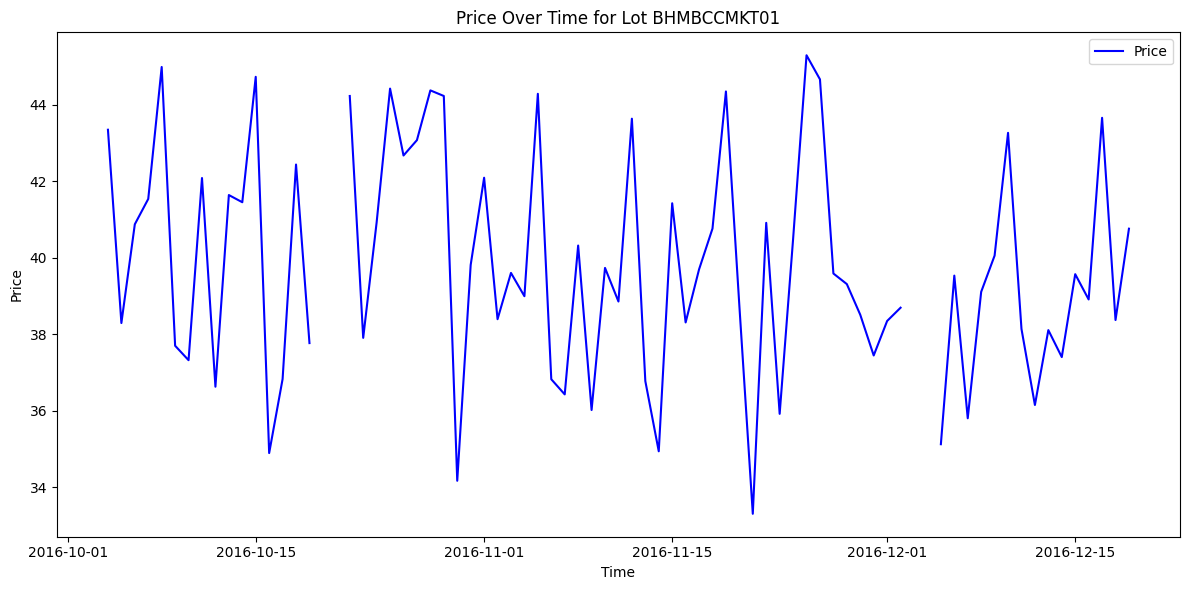

In [ ]:
# Plotting: Baseline Price over Time for a Sample Lot

# Define the parking lot ID for plotting
lot_id = 'BHMBCCMKT01'

# Filter the main DataFrame to get data for the selected lot
df_lot = df[df['SystemCodeNumber'] == lot_id]

# Resample the data to daily frequency and calculate the mean of numeric columns for each day
# Reset the index to make Datetime a regular column again.
df_lot_daily = df_lot.set_index('Datetime').resample('D').mean(numeric_only=True).reset_index()

# Create a new figure for the plot with a specified size (12x6 inches)
plt.figure(figsize=(12,6))

# Plot the 'Price' (baseline price) over time
plt.plot(df_lot_daily['Datetime'], df_lot_daily['Price'], label='Price', color='blue')

# Set the label for the x-axis
plt.xlabel('Time')

# Set the label for the y-axis
plt.ylabel('Price')

# Set the title of the plot, including the lot ID
plt.title(f'Price Over Time for Lot {lot_id}')

# Display the legend to identify the plotted line
plt.legend()

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Save the generated plot to a file in the 'plots' directory
plt.savefig(f'plots/baseline_price_{lot_id}.png')

# Display the plot
plt.show()

In [ ]:
plt.savefig(f'plots/baseline_price_{lot_id}.png')

<Figure size 640x480 with 0 Axes>

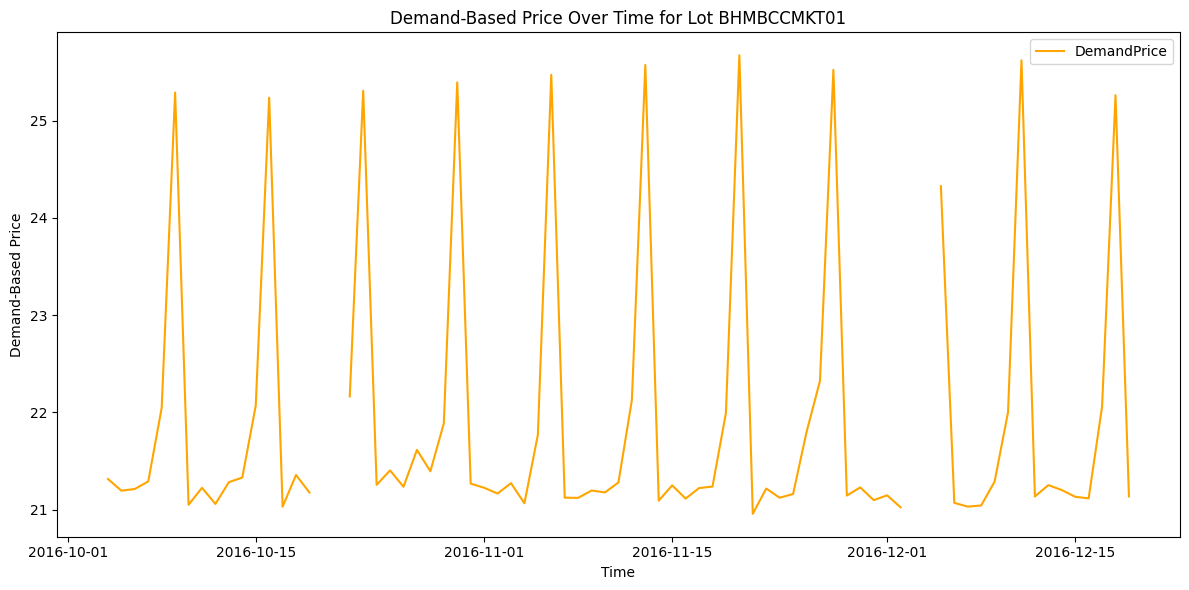

In [ ]:
# Plotting: Demand-Based Price over Time for a Sample Lot

# Filter the main DataFrame to get data for the selected lot (using the previously defined lot_id)
df_lot = df[df['SystemCodeNumber'] == lot_id]

# Resample the data to daily frequency and calculate the mean of numeric columns for each day
# Reset the index to make Datetime a regular column again.
df_lot_daily = df_lot.set_index('Datetime').resample('D').mean(numeric_only=True).reset_index()

# Create a new figure for the plot with a specified size (12x6 inches)
plt.figure(figsize=(12,6))

# Plot the 'DemandPrice' (demand-based price) over time
plt.plot(df_lot_daily['Datetime'], df_lot_daily['DemandPrice'], label='DemandPrice', color='orange')

# Set the label for the x-axis
plt.xlabel('Time')

# Set the label for the y-axis
plt.ylabel('Demand-Based Price')

# Set the title of the plot, including the lot ID
plt.title(f'Demand-Based Price Over Time for Lot {lot_id}')

# Display the legend to identify the plotted line
plt.legend()

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Save the generated plot to a file in the 'plots' directory
plt.savefig(f'plots/demand_based_price_{lot_id}.png')

# Display the plot
plt.show()

In [ ]:
plt.savefig(f'plots/demand_based_price_{lot_id}.png')

<Figure size 640x480 with 0 Axes>

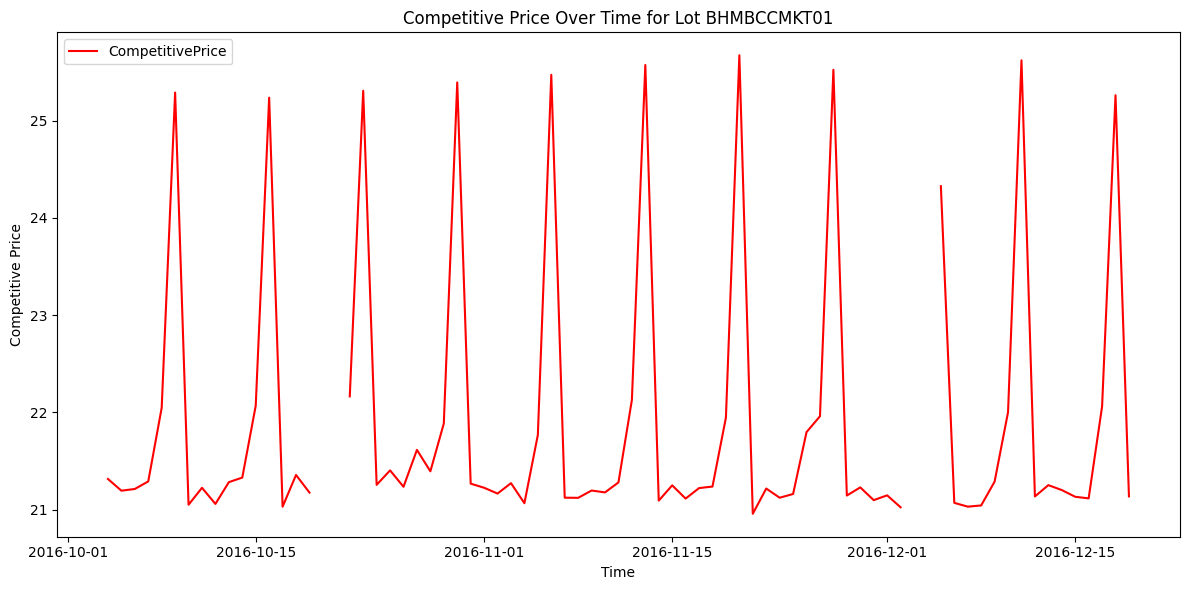

In [ ]:
# Plotting: Competitive Price over Time for a Sample Lot

# Filter the main DataFrame to get data for the selected lot (using the previously defined lot_id)
df_lot = df[df['SystemCodeNumber'] == lot_id]

# Resample the data to daily frequency and calculate the mean of numeric columns for each day
# Reset the index to make Datetime a regular column again.
df_lot_daily = df_lot.set_index('Datetime').resample('D').mean(numeric_only=True).reset_index()

# Create a new figure for the plot with a specified size (12x6 inches)
plt.figure(figsize=(12,6))

# Plot the 'CompetitivePrice' (competitive price) over time
plt.plot(df_lot_daily['Datetime'], df_lot_daily['CompetitivePrice'], label='CompetitivePrice', color='red')

# Set the label for the x-axis
plt.xlabel('Time')

# Set the label for the y-axis
plt.ylabel('Competitive Price')

# Set the title of the plot, including the lot ID
plt.title(f'Competitive Price Over Time for Lot {lot_id}')

# Display the legend to identify the plotted line
plt.legend()

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Save the generated plot to a file in the 'plots' directory
plt.savefig(f'plots/competitive_price_{lot_id}.png')

# Display the plot
plt.show()

In [ ]:

plt.savefig(f'plots/competitive_price_{lot_id}.png')

<Figure size 640x480 with 0 Axes>

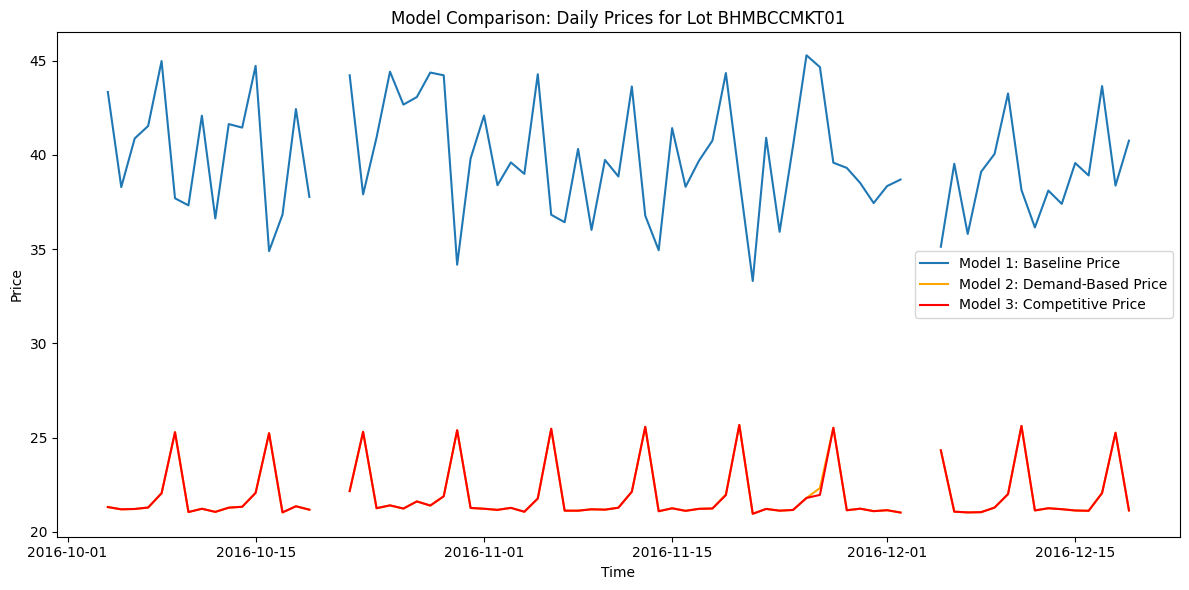

In [ ]:
# Plotting: Model Comparison for a Sample Lot

# Filter the main DataFrame to get data for the selected lot (using the previously defined lot_id)
df_lot = df[df['SystemCodeNumber'] == lot_id]

# Resample the data to daily frequency and calculate the mean of numeric columns for each day
# Reset the index to make Datetime a regular column again.
df_lot_daily = df_lot.set_index('Datetime').resample('D').mean(numeric_only=True).reset_index()

# Create a new figure for the plot with a specified size (12x6 inches)
plt.figure(figsize=(12,6))

# Plot the 'Price' (Model 1: Baseline Price) over time if the column exists
if 'Price' in df_lot_daily.columns:
    plt.plot(df_lot_daily['Datetime'], df_lot_daily['Price'], label='Model 1: Baseline Price')

# Plot the 'DemandPrice' (Model 2: Demand-Based Price) over time if the column exists
if 'DemandPrice' in df_lot_daily.columns:
    plt.plot(df_lot_daily['Datetime'], df_lot_daily['DemandPrice'], label='Model 2: Demand-Based Price', color='orange')

# Plot the 'CompetitivePrice' (Model 3: Competitive Price) over time if the column exists
if 'CompetitivePrice' in df_lot_daily.columns:
    plt.plot(df_lot_daily['Datetime'], df_lot_daily['CompetitivePrice'], label='Model 3: Competitive Price', color='red')

# Set the label for the x-axis
plt.xlabel('Time')

# Set the label for the y-axis
plt.ylabel('Price')

# Set the title of the plot, indicating a comparison of models for the specified lot ID
plt.title(f'Model Comparison: Daily Prices for Lot {lot_id}')

# Display the legend to identify the plotted lines for each model
plt.legend()

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Save the generated plot to a file in the 'plots' directory
plt.savefig(f'plots/model_comparison_{lot_id}.png')

# Display the plot
plt.show()

In [ ]:
plt.savefig(f'plots/model_comparison_{lot_id}.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
# Save the final DataFrame with all calculations and recommendations to a CSV file
# The index is not included in the output file.
df.to_csv('final_results.csv', index=False)

In [ ]:
# Calculate revenue for each model by multiplying the respective price by the occupancy
df['revenue_model_1'] = df['Price'] * df['Occupancy']
df['revenue_model_2'] = df['DemandPrice'] * df['Occupancy']
df['revenue_model_3'] = df['CompetitivePrice'] * df['Occupancy']

# Calculate the total revenue for each model across the entire dataset
rev1 = df['revenue_model_1'].sum()
rev2 = df['revenue_model_2'].sum()
rev3 = df['revenue_model_3'].sum()

# Define the columns to group by for calculating average revenue per day per lot
group_cols = ['SystemCodeNumber', 'Datetime']

# Calculate the total revenue per lot per datetime, then take the mean of these sums
# This gives the average revenue generated by a single lot in a single recorded instance.
rev1_avg = df.groupby(group_cols)['revenue_model_1'].sum().mean()
rev2_avg = df.groupby(group_cols)['revenue_model_2'].sum().mean()
rev3_avg = df.groupby(group_cols)['revenue_model_3'].sum().sum().mean()


# Calculate the average occupancy ratio across all data points
avg_occupancy = (df['Occupancy'] / df['Capacity']).mean()

# Attempt to read the reroute recommendations from the generated CSV file
try:
    reroute_df = pd.read_csv('plots/reroute_recommendations.csv')
    # Get the number of reroute recommendations
    reroute_count = len(reroute_df)
    # Calculate the average saving per reroute recommendation
    # This is the average difference between the lot's demand price and the competitor average price when a reroute is suggested.
    avg_saving = (reroute_df['DemandPrice'] - reroute_df['CompetitorAvgPrice']).mean() if reroute_count > 0 else 0
except Exception:
    # If the file cannot be read or an error occurs, set reroute count and average saving to 0
    reroute_count = 0
    avg_saving = 0

# Print the header for the performance comparison table
print(f"| Model   | Total Revenue | Avg Revenue/Day/Lot | Avg Occupancy | Reroutes | Avg Reroute Saving |")
# Print the separator line for the table header
print(f"|---------|---------------|---------------------|---------------|----------|-------------------|")
# Print the performance metrics for Model 1 (Baseline Price)
print(f"| Model 1 | ₹{rev1:,.2f}  | ₹{rev1_avg:,.2f}    | {avg_occupancy:.2%}     | N/A      | N/A               |")
# Print the performance metrics for Model 2 (Demand-Based Price)
print(f"| Model 2 | ₹{rev2:,.2f}  | ₹{rev2_avg:,.2f}    | {avg_occupancy:.2%}     | N/A      | N/A               |")
# Print the performance metrics for Model 3 (Competitive Price)
# Includes reroute count and average reroute saving.
print(f"| Model 3 | ₹{rev3:,.2f}  | ₹{rev3_avg:,.2f}    | {avg_occupancy:.2%}     | {reroute_count}    | ₹{avg_saving:,.2f}         |\n")

# If there are reroute recommendations, print a sample of them
if reroute_count > 0:
    print("Sample reroute recommendations:")
    # Display the first few rows of the reroute_df with specific columns
    display(reroute_df[['SystemCodeNumber', 'Datetime', 'DemandPrice', 'CompetitorAvgPrice', 'Reroute']].head())
else:
    # If no reroute recommendations, print a message
    print("No reroute recommendations found.")

| Model   | Total Revenue | Avg Revenue/Day/Lot | Avg Occupancy | Reroutes | Avg Reroute Saving |
|---------|---------------|---------------------|---------------|----------|-------------------|
| Model 1 | ₹646,112,237.25  | ₹35,341.44    | 50.91%     | N/A      | N/A               |
| Model 2 | ₹171,221,483.95  | ₹9,365.58    | 50.91%     | N/A      | N/A               |
| Model 3 | ₹170,612,101.17  | ₹9,332.24    | 50.91%     | 741    | ₹0.64         |

Sample reroute recommendations:
  SystemCodeNumber             Datetime  DemandPrice  CompetitorAvgPrice  \
0     Broad Street  2016-10-04 09:59:00    22.608269           21.685065   
1      BHMEURBRD01  2016-10-04 10:26:00    22.898814           22.308967   
2     Broad Street  2016-10-04 10:26:00    23.088643           22.137264   
3      BHMEURBRD01  2016-10-04 12:29:00    22.530586           21.805665   
4     Broad Street  2016-10-04 12:29:00    22.611672           21.805665   

                                             Rerou